In [10]:
import fastf1
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import warnings
from pathlib import Path
import seaborn as sns
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime

warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.WARNING)

fastf1.Cache.enable_cache(os.getcwd())

# Window size (range of the sliding window used in delta angle calculation)
N = 15

# Max and Min delta angle for a data point to be classified as being part of a corner
CORNER_THRESHOLD = 0.4
SPEED_THRESHOLD = 200

## Load and Prepare Formula 1 Race Sessions

In [2]:
year = 2025

schedule = fastf1.get_event_schedule(year)
gp_events = schedule[schedule['EventName'].str.contains("Grand Prix")]['EventName'].tolist()
gp_events = schedule[
    (schedule['EventName'].str.contains("Grand Prix")) &
    (schedule['EventDate'] <= datetime.datetime.now())
]['EventName'].tolist()

sessions = {}

#Loading race session
def load_session(event):
    try:
        session = fastf1.get_session(year, event, 'R')
        session.load(telemetry=True, laps=True, weather=True)
        return event, session
    except Exception as e:
        print(f"Cannot load {event}.")
        return None

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(load_session, e): e for e in gp_events}
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            event, session = result
            sessions[event] = session

core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '81'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	

## Compute Cornering and Telemetry Metrics for Each Race

In [3]:
race_stats = pd.DataFrame()
race_data = []

for event in gp_events:
    session = sessions[event]
    try:
        telemetry = session.laps.pick_driver('VER').get_telemetry()
    except Exception as e:
        print(f"Timing data not available for {event}")
        continue
    telemetry = telemetry[['X', 'Y','Speed']]

    dx1 = telemetry['X'] - telemetry['X'].shift(N)
    dy1 = telemetry['Y'] - telemetry['Y'].shift(N)
    dx2 = telemetry['X'].shift(-N) - telemetry['X']
    dy2 = telemetry['Y'].shift(-N) - telemetry['Y']

    telemetry['Event'] = event

    telemetry['Delta_Angle'] = np.arctan2(dx1*dy2 - dy1*dx2, dx1*dx2 + dy1*dy2)
    telemetry['Delta_Angle'] = telemetry['Delta_Angle'].fillna(0)

    telemetry['IsCorner'] = ((telemetry['Delta_Angle'] > CORNER_THRESHOLD) | (telemetry['Delta_Angle'] < -CORNER_THRESHOLD) | (telemetry['Speed'] < SPEED_THRESHOLD))

    race_data.append(telemetry)

race_stats = pd.concat(race_data, ignore_index=True)
race_stats.to_csv("race_stats.csv", index=False)

### Visualize Telemetry Data and Cornering Events

In [4]:
race_stats_csv = pd.read_csv("race_stats.csv")

for event in race_stats_csv["Event"].unique():
    event_data = race_stats_csv[race_stats_csv["Event"] == event]

    plt.figure(figsize=(6.4, 4.8))
    cmap = sns.color_palette('viridis', as_cmap = True)
    norm = plt.Normalize(vmin=race_stats_csv['Delta_Angle'].min(), vmax=race_stats_csv['Delta_Angle'].max())

    sc = sns.scatterplot(data=event_data,
                        x='X', y='Y',
                        hue='Delta_Angle',
                        palette='viridis',
                        hue_norm=norm,
                        legend=False,
                        edgecolor=None)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = plt.gca())

    plt.savefig(f"{event}_deltaAngle.png")
    plt.close()

    plt.figure(figsize=(6.4, 4.8))
    sns.scatterplot(data=event_data,
                    x='X', y='Y',
                    hue='IsCorner',
                    palette={False: "blue", True: "red"},
                    edgecolor=None)

    plt.savefig(f"{event}_isCorner.png")
    plt.close()

## Extract Driver Lap Statistics and Telemetry Metrics

In [5]:
df = pd.DataFrame()
rows = []

def pick_median(laps):
    valid_laps = laps.dropna(subset=['LapTime']).reset_index(drop=True)
    if valid_laps.empty: return None
    times = valid_laps['LapTime'].dt.total_seconds()
    median_time = np.median(times)
    median_lap_index = (times - median_time).abs().argsort().iloc[0]
    return valid_laps.iloc[median_lap_index]

for event in gp_events:
    session = sessions[event]
    weather = session.weather_data
    
    for num in session.drivers:
        driver = session.get_driver(num)['Abbreviation']
        team = session.get_driver(num)['TeamName']
        
        
        driver_laps_all = session.laps.pick_driver(driver)
        if driver_laps_all.empty:
            continue
        
        #TODO filter out wet weather laps
        driver_laps_race = driver_laps_all[( driver_laps_all['TrackStatus'] == '1') 
                                           & (driver_laps_all['PitInTime'].isna()) 
                                           & (driver_laps_all['PitOutTime'].isna()) 
                                           & (driver_laps_all['LapNumber'] > 1)].dropna(subset='LapTime').reset_index(drop=True)
        #INCLUDES laps done under green flag conditions, EXCLUDES pit in, pit out laps, as well as first lap
        
        lap_median = pick_median(driver_laps_race)
        lap_fastest = driver_laps_race.pick_fastest()
        if lap_median is None or lap_fastest is None: continue
        tel_median = lap_median.get_car_data()

        corner_speeds = tel_median.query('Speed < 200')['Speed']
        straight_speeds = tel_median.query('Speed >= 200')['Speed']

        #Getting TopSpeed with and without DRS
        top_speed = 0
        top_speed_no_drs = 0
        for _, lap in driver_laps_race.iterlaps():
            tel = lap.get_car_data()
            if 'Speed' in tel:
                lap_top_speed = tel['Speed'].max()
                if lap_top_speed > top_speed:
                    top_speed = lap_top_speed
            else:
                continue
            
            drs = tel['DRS'].values
            if 'Speed' in tel and drs.max() < 2: # looks for laps with no DRS enabled
                lap_top_speed = tel['Speed'].max()
                if lap_top_speed > top_speed_no_drs:
                    top_speed_no_drs = lap_top_speed
            else:
                continue

        drs_delta = top_speed - top_speed_no_drs
        #TODO add TopSpeed without drs and drs delta to df if needed

        rows.append(
            {
                "Driver": driver,
                "Team": team,
                "Event": event,
                "TyreCompound": lap_fastest['Compound'] if 'Compound' in lap_fastest else None,
                "QualifyingTime": lap_fastest['LapTime'].total_seconds() if lap_fastest['LapTime'] else None, 
                "TopSpeed": top_speed,
                "TopSpeedNoDelta": top_speed_no_drs,
                "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                "ThrottleMean": tel_median['Throttle'].mean(),
                "ThrottleStdDev": tel_median['Throttle'].std(),
                "BrakeMean": tel_median['Brake'].mean(),
                "BrakeStdDev": tel_median['Brake'].std(),
                "DRSMean": tel_median['DRS'].mean(),
                # "DRSDelta": drs_delta
            }
        )

        
        # df.at[i, 'AirTemp'] = weather['AirTemp']
        # df.at[i, 'TrackTemp'] = weather['TrackTemp']
        # df.at[i, 'Humidity'] = weather['Humidity']
        # df.at[i, 'Pressure'] = weather['Pressure']
        # df.at[i, 'Rainfall'] = weather['Rainfall']

df = pd.DataFrame(rows)

In [ ]:
df['DRSDelta'].describe()

df = df[df['DRSDelta'] < 200]

In [7]:
df['TopSpeed'].dtype

dtype('float64')

In [8]:
df.to_csv('f1.csv', index = False)

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("f1.csv")
df.dropna(inplace=True)

## Assess Multicollinearity in Telemetry Features

In [163]:
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_columns.remove("QualifyingTime")

# Check VIF (Multicolinearity)
formula = f'Q("QualifyingTime") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                      variable          VIF
0                    Intercept  6010.150500
1                Q("TopSpeed")     3.569940
2         Q("TopSpeedNoDelta")     1.823458
3          Q("AvgCornerSpeed")     3.135357
4     Q("AvgCornerEntrySpeed")     1.148060
5      Q("AvgCornerExitSpeed")     1.044338
6        Q("AvgStraightSpeed")     5.618864
7   Q("AvgStraightEntrySpeed")    16.806083
8    Q("AvgStraightExitSpeed")    15.685651
9            Q("ThrottleMean")     8.776487
10         Q("ThrottleStdDev")     2.461949
11              Q("BrakeMean")    26.576697
12            Q("BrakeStdDev")    30.427943
13                Q("DRSMean")     1.193304


In [164]:
# Check VIF again (Multicolinearity)
continuous_columns.remove("BrakeStdDev")
continuous_columns.remove("AvgStraightExitSpeed")
continuous_columns.remove("AvgStraightSpeed")

formula = f'Q("QualifyingTime") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                      variable          VIF
0                    Intercept  2692.411506
1                Q("TopSpeed")     2.941255
2         Q("TopSpeedNoDelta")     1.707151
3          Q("AvgCornerSpeed")     1.848860
4     Q("AvgCornerEntrySpeed")     1.113336
5      Q("AvgCornerExitSpeed")     1.017659
6   Q("AvgStraightEntrySpeed")     1.432548
7            Q("ThrottleMean")     5.775343
8          Q("ThrottleStdDev")     2.127878
9               Q("BrakeMean")     2.696647
10                Q("DRSMean")     1.102006


## Build and Evaluate Machine Learning Models

In [196]:
x = df.drop(columns=['QualifyingTime'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y = df['QualifyingTime']

modelval_df = pd.DataFrame(columns=['Model', 'R-Squared', 'RMSE'])
modelval_df

,Model,R-Squared,RMSE


In [197]:
print(f"The shape of the df is {df.shape}\n")
print(f"The driver distribution by {df.groupby('Team').size()}\n")
print(f"The size of the df is {df.size}\n")
print("Quick statistical data of the df\n") 
print(df.describe(), "\n")
print("Data column description\n") 
print(df.info())

The shape of the df is (339, 18)

The driver distribution by Team
Alpine             31
Aston Martin       33
Ferrari            36
Haas F1 Team       36
Kick Sauber        32
McLaren            35
Mercedes           34
Racing Bulls       34
Red Bull Racing    34
Williams           34
dtype: int64

The size of the df is 6102

Quick statistical data of the df

       QualifyingTime    TopSpeed  TopSpeedNoDelta  AvgCornerSpeed  \
count      339.000000  339.000000       339.000000      339.000000   
mean        86.773375  331.203540       313.793510      138.470634   
std         10.578896   15.838026        21.130025        8.927505   
min         67.924000  283.000000         0.000000      117.348039   
25%         77.942000  323.000000       308.000000      131.692883   
50%         86.764000  335.000000       315.000000      142.136095   
75%         95.519000  341.000000       322.000000      145.624978   
max        107.667000  365.000000       346.000000      152.382609   

       

### Linear Regression

In [201]:
x_reduced = x.drop(columns=["BrakeStdDev"])
x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

model_lm = LinearRegression()
model_lm.fit(x_train, y_train)

y_pred_lm = model_lm.predict(x_test)

r2_lm = r2_score(y_test, y_pred_lm)
rmse_lm = root_mean_squared_error(y_test, y_pred_lm)


modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Linear Regression',
                                                     'R-Squared': r2_lm,
                                                     'RMSE': rmse_lm}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_lm}")
print(f"RMSE: {rmse_lm}")

modelval_df = modelval_df.drop_duplicates()
modelval_df

R-Squared: 0.9935442921423003
RMSE: 0.857860654079852


,Model,R-Squared,RMSE
0,Linear Regression,0.993544,0.857861


### Random Forest Regressor

In [202]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

rf = RandomForestRegressor(random_state=1)

param_grid = {'n_estimators': list(range(31, 41)),
              'min_samples_leaf': list(range(1, 5))
              }

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

grid_search_rf.fit(x_train, y_train)

print("Best params:", grid_search_rf.best_params_)
# print("Train RMSE:", -grid_search.best_score_)

best_rf = grid_search_rf.best_estimator_

y_pred = best_rf.predict(x_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = root_mean_squared_error(y_test, y_pred)

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Random Forest Regression',
                                                     'R-Squared': r2_rf,
                                                     'RMSE': rmse_rf}])
                                                     ], ignore_index=True)

print(f"Test R-Squared: {r2_rf}")
print(f"Test RMSE: {rmse_rf}")

modelval_df = modelval_df.drop_duplicates()
modelval_df
# importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
# importances.sort_values().plot(kind='barh')
# plt.show()

Best params: {'min_samples_leaf': 1, 'n_estimators': 37}
Test R-Squared: 0.9743237303807378
Test RMSE: 1.7108454478268535


,Model,R-Squared,RMSE
0,Linear Regression,0.993544,0.857861
1,Random Forest Regression,0.974324,1.710845


### XGBoost Regressor

In [204]:
import xgboost as xgb

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

xg = xgb.XGBRegressor(random_state=1)

param_grid = {"n_estimators": [690, 700, 710],
              "learning_rate": [0.04]
              }

grid_search_xgb = GridSearchCV(
    estimator=xg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

grid_search_xgb.fit(x_train, y_train)

print("Best params:", grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_

y_pred = grid_search_xgb.predict(x_test)

r2_xg = r2_score(y_test, y_pred)
rmse_xg = root_mean_squared_error(y_test, y_pred)

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'XGBoost Regression',
                                                     'R-Squared': r2_xg,
                                                     'RMSE': rmse_xg}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_xg}")
print(f"RMSE: {rmse_xg}")

modelval_df = modelval_df.drop_duplicates()
modelval_df

# importances = pd.Series(best_xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
# importances.sort_values().plot(kind='barh')
# plt.show()

Best params: {'learning_rate': 0.04, 'n_estimators': 710}
R-Squared: 0.9843810185376977
RMSE: 1.334354330989215


,Model,R-Squared,RMSE
0,Linear Regression,0.993544,0.857861
1,Random Forest Regression,0.974324,1.710845
2,XGBoost Regression,0.984381,1.334354


                      Model  R-Squared      RMSE
0         Linear Regression   0.993544  0.857861
1  Random Forest Regression   0.974324  1.710845
2        XGBoost Regression   0.984381  1.334354


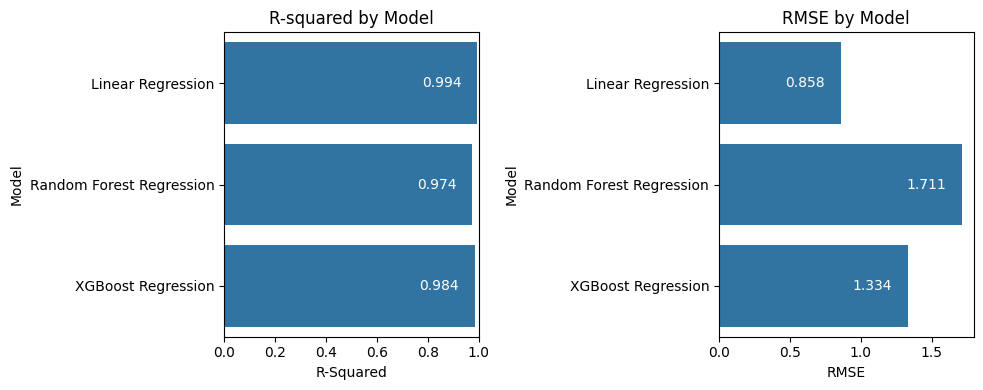

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

print(modelval_df)

sns.barplot(y='Model', x='R-Squared', data=modelval_df, ax=ax[0])
ax[0].set_title('R-squared by Model')
ax[0].set_xlim(0, 1)
for p in ax[0].patches:
    ax[0].annotate(
        format(p.get_width(), '.3f'),     
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),       
        textcoords='offset points'
    )

sns.barplot(y='Model', x='RMSE', data=modelval_df, ax=ax[1])
ax[1].set_title('RMSE by Model')
for p in ax[1].patches:
    ax[1].annotate(
        format(p.get_width(), '.3f'),
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

# Classifiers

In [206]:
labels = []
median_straight = df['AvgStraightSpeed'].median()
median_corner = df['AvgCornerSpeed'].median()

std_straight = df['AvgStraightSpeed'].std()
std_corner = df['AvgCornerSpeed'].std()

threshold = 0.5

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in df.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold * std_straight
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold * std_corner

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

### k-Nearest Neighbors

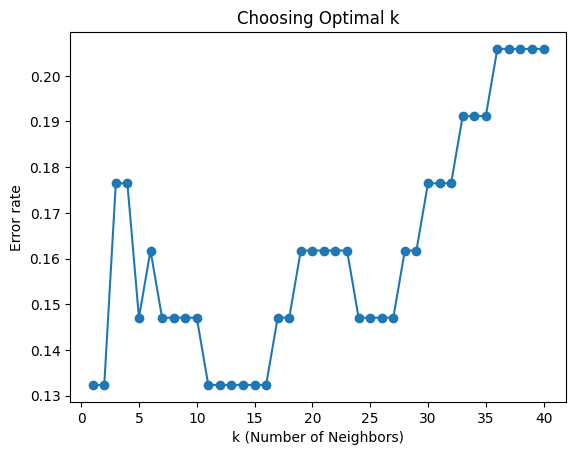

Best k: 1
Accuracy: 0.8676470588235294
F1: 0.8668956287334211
                   precision    recall  f1-score   support

      Bad at both       0.93      0.90      0.92        42
     Good at both       1.00      0.75      0.86         4
  Good in corners       0.43      0.43      0.43         7
Good in straights       0.88      1.00      0.94        15

         accuracy                           0.87        68
        macro avg       0.81      0.77      0.78        68
     weighted avg       0.87      0.87      0.87        68

[[38  0  4  0]
 [ 0  3  0  1]
 [ 3  0  3  1]
 [ 0  0  0 15]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}


In [303]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold

df_knn = df.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

# x-axis for KNN
x = df_knn.drop(columns=['QualifyingTime', 'Driver', 'Team', 'Event', 'TyreCompound'])
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

# y-axis for kNN
le = LabelEncoder()
y = le.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size = 0.2, random_state = 1, stratify = y)

# Finding optimal k value
k_values = range(1, 41)   # Try k = 1 to 40
error_rate = []

p = 2

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k, p=p)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    error_rate.append(np.mean(predictions != y_test))

best_k = error_rate.index(min(error_rate)) + 1

plt.plot(k_values, error_rate, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error rate")
plt.title("Choosing Optimal k")
plt.show()
print("Best k:", best_k)

#Run proper kNN
knn = KNeighborsClassifier(n_neighbors = best_k, p=p)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())


In [209]:
print("y train: ", np.unique(y_train, return_counts=True))
print("y test: ", np.unique(y_test, return_counts=True))

y train:  (array([0, 1, 2, 3]), array([166,  15,  31,  59]))
y test:  (array([0, 1, 2, 3]), array([42,  4,  7, 15]))


### Support Vector Machine

In [238]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

df_svm = df.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

# x-axis for SVM
x = df_svm.drop(columns=['QualifyingTime', 'Driver', 'Team', 'Event', 'TyreCompound'])
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_reduced)

#y-axis for SVM
y = LabelEncoder().fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 1, stratify = y)

#SVM
svm = SVC(kernel='poly', C=6)
svm.fit(x_train, y_train)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())

Accuracy: 0.9264705882352942
F1: 0.9157037230910162
                   precision    recall  f1-score   support

      Bad at both       0.93      1.00      0.97        42
     Good at both       0.75      0.75      0.75         4
  Good in corners       1.00      0.43      0.60         7
Good in straights       0.94      1.00      0.97        15

         accuracy                           0.93        68
        macro avg       0.91      0.79      0.82        68
     weighted avg       0.93      0.93      0.92        68

[[42  0  0  0]
 [ 0  3  0  1]
 [ 3  1  3  0]
 [ 0  0  0 15]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}


### Naive Bayes Classifier

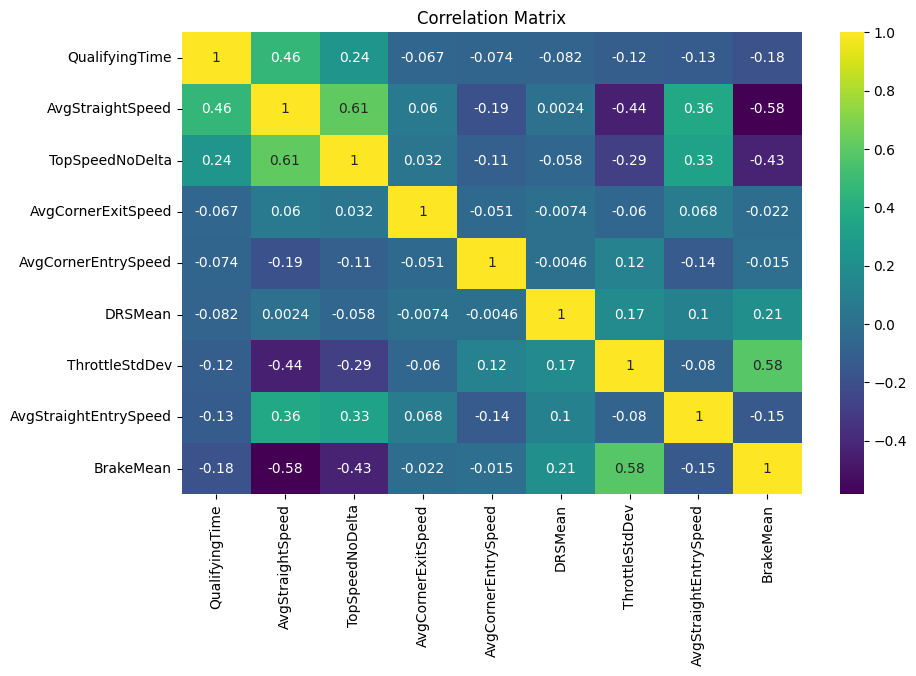

Accuracy: 0.8088235294117647
F1: 0.8214071069040643
                   precision    recall  f1-score   support

      Bad at both       0.90      0.83      0.86        42
     Good at both       0.75      0.75      0.75         4
  Good in corners       0.36      0.57      0.44         7
Good in straights       0.93      0.87      0.90        15

         accuracy                           0.81        68
        macro avg       0.73      0.76      0.74        68
     weighted avg       0.84      0.81      0.82        68

[[35  0  7  0]
 [ 0  3  0  1]
 [ 2  1  4  0]
 [ 2  0  0 13]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}


In [304]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# TODO: Move corr map to data viz section + discuss suitability of NB model

# remove highly correlated columns
nb_df1 = df.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

x = nb_df1.drop(columns=['QualifyingTime', 'Driver', 'Team', 'Event', 'TyreCompound'])
y_encoded = LabelEncoder().fit_transform(labels)

# ---quality correlation matrix---
numeric_df = nb_df1.select_dtypes(include=np.number)
k = len(numeric_df.columns) - 1 # number of variables for heatmap
cols = numeric_df.corr().nlargest(k, 'QualifyingTime')['QualifyingTime'].index #change QT 
cm = numeric_df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title('Correlation Matrix')
plt.show()
plt.close()

# dividing data
# nb_df1_features = nb_df1.drop(['QualifyingTime', 'PerformanceCategory'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())

# Logistic Regression

In [305]:
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

y_pred = nb.predict(x_test)  #evaluate the classifier by score 
acc = metrics.accuracy_score(y_test, y_pred)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())

Accuracy: 0.8088235294117647
F1: 0.8214071069040643
                   precision    recall  f1-score   support

      Bad at both       0.90      0.83      0.86        42
     Good at both       0.75      0.75      0.75         4
  Good in corners       0.36      0.57      0.44         7
Good in straights       0.93      0.87      0.90        15

         accuracy                           0.81        68
        macro avg       0.73      0.76      0.74        68
     weighted avg       0.84      0.81      0.82        68

[[35  0  7  0]
 [ 0  3  0  1]
 [ 2  1  4  0]
 [ 2  0  0 13]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}


### K Means

     Cluster_Corner Driver                Event             Team
191               0    ALB  Canadian Grand Prix         Williams
187               0    HAD  Canadian Grand Prix     Racing Bulls
186               0    GAS  Canadian Grand Prix           Alpine
185               0    BOR  Canadian Grand Prix      Kick Sauber
183               0    TSU  Canadian Grand Prix  Red Bull Racing
..              ...    ...                  ...              ...
196               4    RUS  Austrian Grand Prix         Mercedes
197               4    LAW  Austrian Grand Prix     Racing Bulls
198               4    ALO  Austrian Grand Prix     Aston Martin
184               4    COL  Canadian Grand Prix           Alpine
171               4    ALB   Spanish Grand Prix         Williams

[344 rows x 4 columns]

Corner Speed clustering RMSE: 5.714951203964537 

     Cluster_Straight Driver                  Event             Team
0                   0    NOR  Australian Grand Prix          McLaren
166    

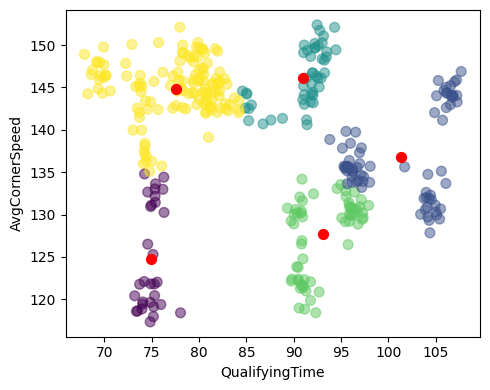

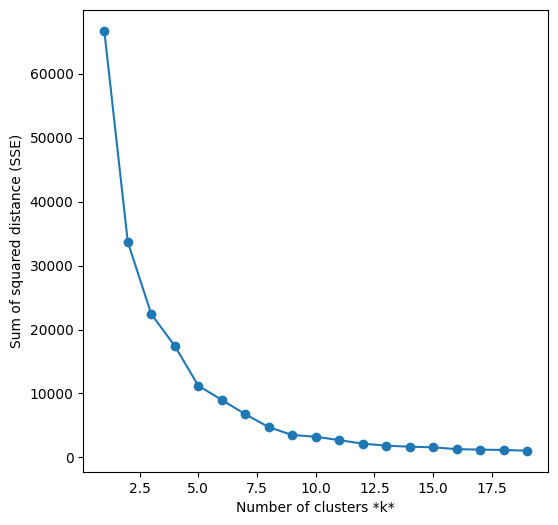

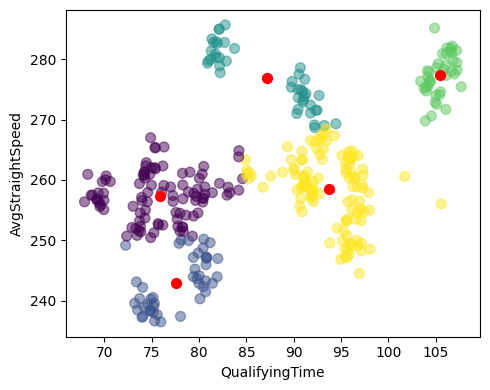

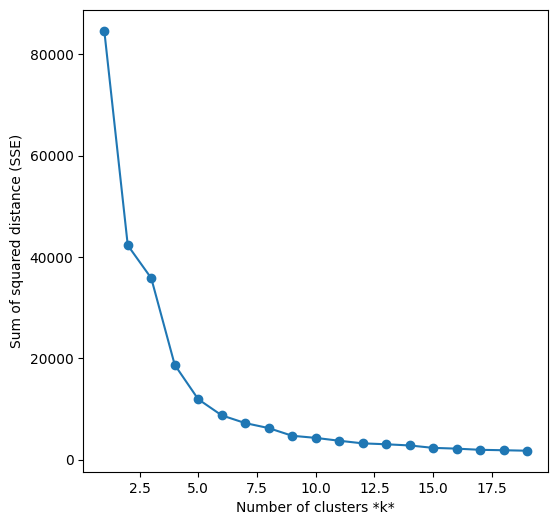

In [30]:
#k-means
from sklearn.cluster import KMeans

x = df['QualifyingTime']
hue1 = df['Driver']

# ----data exploration---
plt.figure(figsize=(10,5))
plot1 = plt.subplot(1,2,1)
sns.scatterplot(x=x, y=df['AvgCornerSpeed'], hue=hue1) #Corner speed plot
plot1.set_title('Avg Corner Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot1.text(x.iloc[i]+0.05, df['AvgCornerSpeed'].iloc[i]+0.05, driver, fontsize=7)

plot2 = plt.subplot(1,2,2)
sns.scatterplot(x=x, y=df['AvgStraightSpeed'], hue=hue1) #Straight speed plot
plot2.set_title('Avg Straight Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot2.text(x.iloc[i]+0.05, df['AvgStraightSpeed'].iloc[i]+0.05, driver, fontsize=7)

# making common legend
handles, labels = plt.gca().get_legend_handles_labels()
plot1.get_legend().remove()
plot2.get_legend().remove()
plt.legend(handles, labels, title='Driver', loc='center left', bbox_to_anchor=(1.02, 0.5),
           fontsize=7, title_fontsize=8, markerscale=0.6, frameon=False)

plt.tight_layout()
plt.close()

# ---apply k-means clustering (CORNER SPEED)---
features = ['QualifyingTime', 'AvgCornerSpeed']
X = df[features]

kmeans = KMeans(n_clusters=5, random_state=0) #change n clusters here
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# --accessing corner clusters---
df['Cluster_Corner'] = kmeans.labels_
cluster_summary = df[['Cluster_Corner', 'Driver', 'Event', 'Team']].copy()
corner_cluster_summary = cluster_summary.sort_values(by='Cluster_Corner')
print(corner_cluster_summary)
# print("Corner speed clustering\n")
# for cluster_id in sorted(df['Cluster_Corner'].unique()):
#     cluster_drivers = df.loc[df['Cluster_Corner'] == cluster_id, 'Driver'].unique()
#     print(f"Cluster {cluster_id+1}: {', '.join(cluster_drivers)}")

# Compute RMSE manually
squared_errors = np.sum((X - centroids[labels])**2, axis=1)
cluster_rmse = np.sqrt(np.mean(squared_errors))
print("\nCorner Speed clustering RMSE:", cluster_rmse, '\n')

fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot also the training points
ax.scatter(df['QualifyingTime'], df['AvgCornerSpeed'], 
           c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_xlabel('QualifyingTime')
ax.set_ylabel('AvgCornerSpeed')

plt.tight_layout()

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (SSE)');

optimal_k = list_k[np.argmin(sse)]
# print(f"Optimal k (Corner): {optimal_k}")

# k = 4, RMSE: 7.119152791342602
# k = 5, RMSE: 5.714951203964537
# k = 6, RMSE: 5.115017385070826
# Value of k = 5 is optimal for corner speed

# ---apply k-means clustering (STRAIGHT SPEED)---
features = ['QualifyingTime', 'AvgStraightSpeed']
X = df[features]

kmeans = KMeans(n_clusters=5, random_state=0) #change n cluster here
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# ---accessing straight clusters---
df['Cluster_Straight'] = kmeans.labels_
cluster_summary = df[['Cluster_Straight', 'Driver', 'Event', 'Team']].copy()
straight_cluster_summary = cluster_summary.sort_values(by='Cluster_Straight')
print(straight_cluster_summary)
# print("Straight speed clustering\n")
# for cluster_id in sorted(df['Cluster_Straight'].unique()):
#     cluster_drivers = df.loc[df['Cluster_Straight'] == cluster_id, 'Driver'].unique()
#     print(f"Cluster {cluster_id+1}: {', '.join(cluster_drivers)}")

# Compute RMSE manually
squared_errors = np.sum((X - centroids[labels])**2, axis=1)
straight_rmse = np.sqrt(np.mean(squared_errors))
print("\nStraight Speed RMSE:", straight_rmse)

fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot also the training points
ax.scatter(df['QualifyingTime'], df['AvgStraightSpeed'], 
           c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_xlabel('QualifyingTime')
ax.set_ylabel('AvgStraightSpeed')

plt.tight_layout()

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (SSE)')

optimal_k = list_k[np.argmin(sse)]

# k = 4, RMSE: 7.374756922414497
# k = 5, RMSE: 5.8885749444040645
# k = 6, RMSE: 5.041792937435824
# Value of k = 5 is optimal for straight speed


### PCA

Explained variance ratio (all PCs): [0.09468245 0.05144174 0.04398358 0.03735007 0.03502971 0.03409175
 0.03357769 0.03337308 0.03289644 0.03188335 0.029566   0.02933235]
Total variance (all PCs): 0.4872082020963773
Variance explained by PC1 and PC2: 0.1461


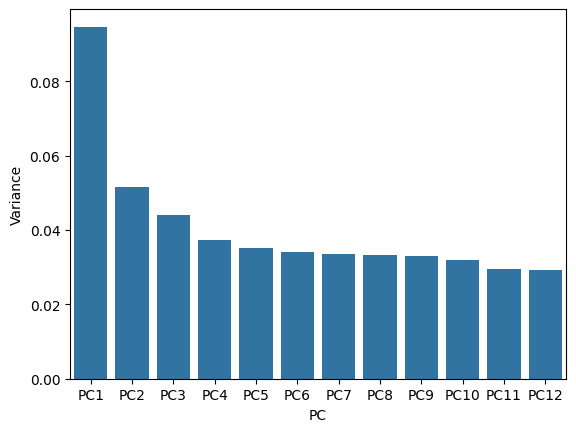

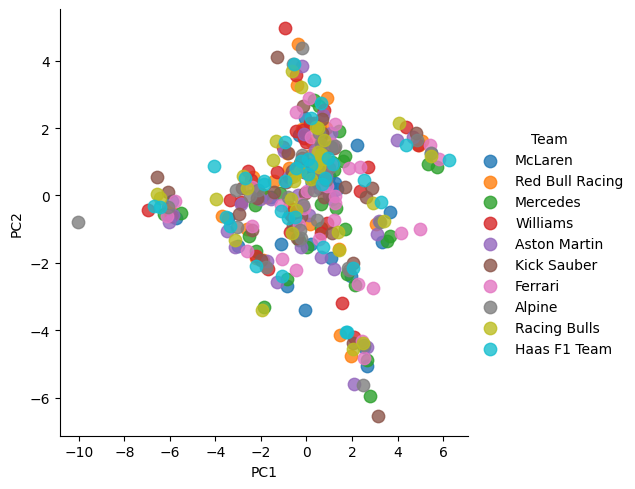

In [68]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load dataset
# features = ['TopSpeed','QualifyingTime','AvgCornerSpeed','AvgCornerEntrySpeed','AvgCornerExitSpeed',
        #     'AvgStraightSpeed','AvgStraightEntrySpeed','AvgStraightExitSpeed']

x = df.drop(columns=["QualifyingTime"]) # Separating out the features
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
x_scaled = StandardScaler().fit_transform(x) # Standardizing the features

def plot_pca(x, y, target,component_num=12, pc_x=1, pc_y=2):
        y = df[target] # Separating out the target
        pca = PCA(n_components=component_num)
        pc = pca.fit_transform(x)

        #2D table
        pc_cols = [f'PC{i+1}' for i in range(component_num)]
        pc_df = pd.DataFrame(data = pc , columns = pc_cols)
        pc_df[target] = y.values
        #print(pc_df.head()) #check

        print("Explained variance ratio (all PCs):",pca.explained_variance_ratio_)
        total_var = np.sum(pca.explained_variance_ratio_)
        print("Total variance (all PCs):", total_var)
        chosen_var = (pca.explained_variance_ratio_[pc_x-1] + 
                      pca.explained_variance_ratio_[pc_y-1])
        print(f"Variance explained by PC{pc_x} and PC{pc_y}: {chosen_var:.4f}")

        #Variance plot of all the PCs
        var_df = pd.DataFrame({
                'Variance':pca.explained_variance_ratio_,
                'PC':[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]})
        sns.barplot(x='PC',y="Variance", data=var_df)

        #PCA visualization
        pcx, pcy = f'PC{pc_x}', f'PC{pc_y}'
        sns.lmplot(x=pcx, y=pcy,
                data=pc_df, 
                fit_reg=False, 
                hue=target, # color by cluster
                legend=True,
                scatter_kws={"s": 80}) # specify the point size

plot_pca(x_scaled, y, target='Team',component_num=12, pc_x=1, pc_y=2) #change pc_x and pc_y value to change PC view